# MNIST：手書き数字の認識

　手書き数字（28×28ピクセル）のグレースケール画像を10個のカテゴリ（0～9）に分類する。

　ここで使用するデータセットはMNIST（Mixed National Institute of Standards and Technology）である。このデータセットを用いた機械学習は、機械学習コミュニティにおける「Hello, World」的ポジションにある。MNISTは、60,000個の訓練画像と10,000個のテスト画像で構成されている。

In [1]:
# MNISTデータセットの読み込み
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 134s 12us/step


In [7]:
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


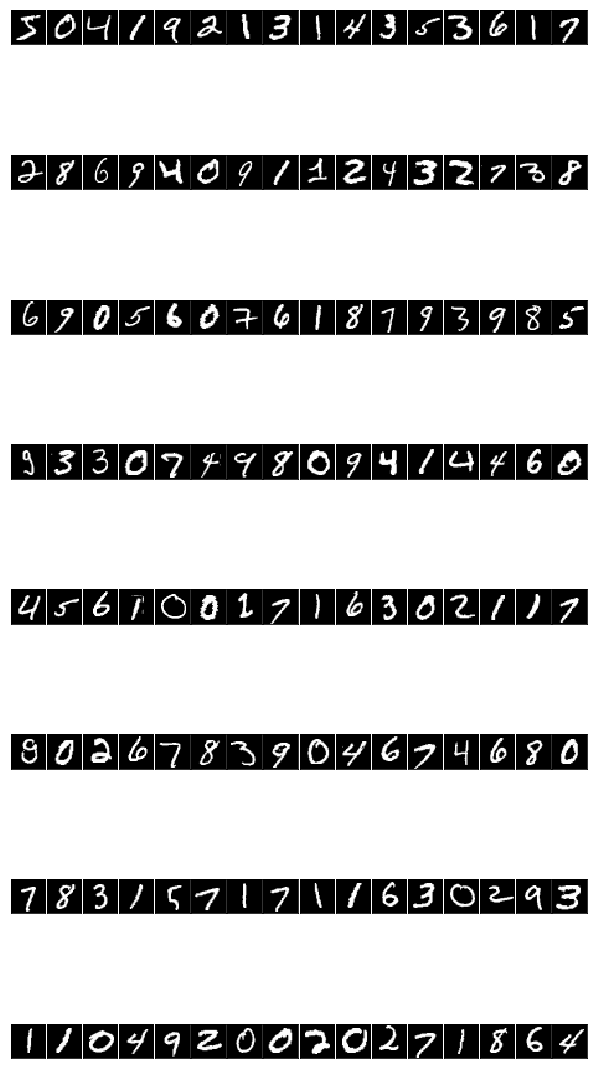

In [3]:
''' 手書き数字の画像を確認 '''
import matplotlib.pyplot as plt
%matplotlib inline

# MNISTデータの表示
W = 16  # 横に並べる個数
H = 8   # 縦に並べる個数
fig = plt.figure(figsize=(H, W))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1.0, hspace=0.05, wspace=0.05)
for i in range(W * H):
    ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
    ax.imshow(train_images[i].reshape((28, 28)), cmap='gray')

plt.show()

## ロジスティック回帰による学習

　まずは、古典的な機械学習の一つであるロジスティック回帰による学習を行ってみる。Kerasでロジスティック回帰を実装するには、10ユニット（0～9にカテゴライズするため）の全結合層に”softmax”活性化関数を適用すれば良い。

In [5]:
# ロジスティック回帰モデルの作成
from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(10, input_dim=28*28))
model.add(layers.Activation('softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# データの正規化
x_train = train_images.reshape((60000, 28 * 28))
x_train = x_train.astype('float32') / 255

x_test = test_images.reshape((10000, 28 * 28))
x_test = x_test.astype('float32') / 255

In [9]:
# ラベルのベクトル化
from keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [10]:
# モデルの訓練
history = model.fit(x_train, y_train, epochs=8, batch_size=128)
result = model.evaluate(x_test, y_test) # 訓練済みモデルの精度を算出
result

Epoch 1/8
60000/60000 [==============================] - 4s 61us/step - loss: 0.6008 - acc: 0.8505
Epoch 2/8
60000/60000 [==============================] - 1s 14us/step - loss: 0.3307 - acc: 0.9083
Epoch 3/8
60000/60000 [==============================] - 1s 14us/step - loss: 0.3017 - acc: 0.9163
Epoch 4/8
60000/60000 [==============================] - 1s 14us/step - loss: 0.2886 - acc: 0.9202
Epoch 5/8
60000/60000 [==============================] - 1s 14us/step - loss: 0.2806 - acc: 0.9223
Epoch 6/8
60000/60000 [==============================] - 1s 14us/step - loss: 0.2748 - acc: 0.9240
Epoch 7/8
60000/60000 [==============================] - 1s 14us/step - loss: 0.2707 - acc: 0.9245
Epoch 8/8
10000/10000 [==============================] - 0s 22us/step


[0.26983632998168466, 0.9254]

上記結果より、ロジスティック回帰による訓練では、精度92％を達成できた。

## 畳み込みニューラルネットワークによる訓練

　古典的な機械学習の一つであるロジスティック回帰では、精度92％を達成できた。続いて、画像認識の分野における革新的なディープラーニングの一つである畳み込みニューラルネットワーク（CNN）による学習を行ってみる。

　CNNは、基本的にConv2D層とMaxPooling2D層のスタックで構成されている。また、CNNの入力テンソルは(image_width, image_height, image_channels)（バッチ次元を含まない）という形状である必要がある。

In [12]:
# CNNモデルの作成
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


In [13]:
# CNNの上に分類器を追加
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
__________

In [14]:
# CNN用にデータを正規化
x_train = train_images.reshape((60000, 28, 28, 1))
x_train = x_train.astype('float32') / 255

x_test = test_images.reshape((10000, 28, 28, 1))
x_test = x_test.astype('float32') / 255

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# モデルの訓練
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.fit(x_train, y_train, epochs=8, batch_size=64)

# 訓練済みモデルの精度評価
model.evaluate(x_test, y_test)

Epoch 1/8
60000/60000 [==============================] - 5s 79us/step - loss: 0.1755 - acc: 0.9448
Epoch 2/8
60000/60000 [==============================] - 4s 65us/step - loss: 0.0462 - acc: 0.9855
Epoch 3/8
60000/60000 [==============================] - 4s 64us/step - loss: 0.0310 - acc: 0.9899
Epoch 4/8
60000/60000 [==============================] - 4s 64us/step - loss: 0.0241 - acc: 0.9928
Epoch 5/8
60000/60000 [==============================] - 4s 64us/step - loss: 0.0189 - acc: 0.9942
Epoch 6/8
60000/60000 [==============================] - 4s 65us/step - loss: 0.0159 - acc: 0.9953
Epoch 7/8
60000/60000 [==============================] - 4s 65us/step - loss: 0.0139 - acc: 0.9959
Epoch 8/8
10000/10000 [==============================] - 0s 44us/step


[0.028886323292832368, 0.9921]

上記の通り、CNNを使ったニューラルネットワークでは、精度99％を達成することができた。